# The Transformation and Hit & Miss methods 

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 08-11-2018 (latest update)
***

Python notebook for illustrating how to generate random numbers following a specific PDF using uniformly distributed random numbers. Both the Hit & Miss / Accept-Reject (Von Neumann) and transformation methods are used.

The purpose of this exercise is to combine Transformation and Hit-and-Miss methods to evaluate an integral (here only in 1D, to make it easy/illustrative).

For more information see:
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-techniques.pdf)__

***

First we import the needed modules:

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit     # The actual fitting tool, better than scipy's
from probfit import BinnedLH, Chi2Regression, Extended, gaussian
import sys                                             # Modules to see files and folders in directories
from scipy import stats

Load external functions:

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

set the parameters of the program:

In [3]:
r = np.random
r.seed(42)

save_plots = False
N_points = 10000 # number of random points used 

xmin = 0
xmax = 20
N_bins = 100

## Problem 1: 

#### Produce random points following $f(x) \sim \exp(-x/3), x \in [0, \infty]$.

To produce random numbers according to $f(x)$ we use the transformation method:


In [4]:
x = -3 * np.log(r.uniform(size=N_points))

And to make sure that we have computed the points correctly, we plot a histogram of the data:

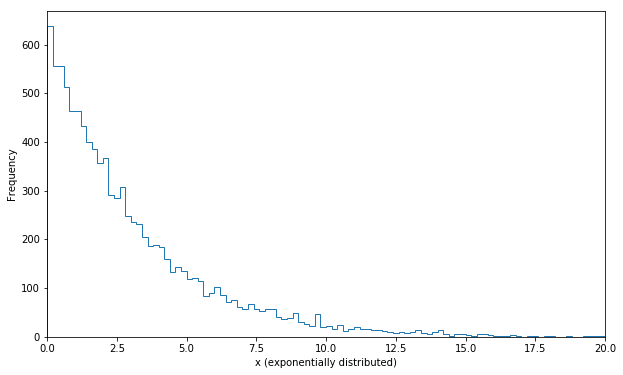

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x, bins=100, range=(xmin, xmax), histtype='step', label='histogram' )
ax.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(0.0, 20.0));

And plot $f(x)$ on top of the figure (notice, no fit here!) along with the legend, figure text and finally saves the figure:

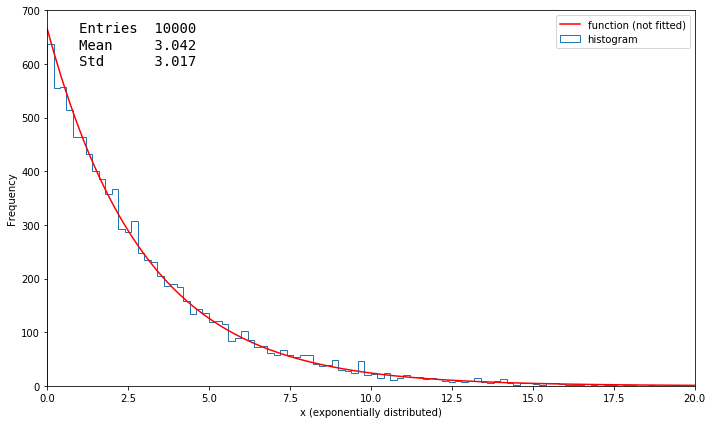

In [6]:
# f(x)
def exp_func(x) :
    # Normalization is N_points * binwidth = 2000:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * 1/3 * np.exp(-x/3)

# plot f(x)
x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = exp_func(x_axis1)
ax.plot(x_axis1, y_axis1, 'r-', label='function (not fitted)')

# define figure text
d = {'Entries': len(x),
     'Mean': x.mean(),
     'Std': x.std(ddof=1),
    }

# plot figure text
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.97, text, ax, fontsize=14)

# add legend
ax.legend(loc='best')
fig.tight_layout()

# save figure
if save_plots: 
    fig.savefig("Hist_exp.pdf", dpi=600)

# show the figure
fig

And we see how we have succesfully generated random numbers according to $f(x)$ via the transformation method. Notice that if this method, if applicable, is 100% effective! 

## Problem 2: 

#### Produce random points following $g(x) \sim x \cos(x), x \in [0, \frac{\pi}{2}]$.

To produce random numbers according to $g(x)$ we use the hit and miss (HnM) method since we cannot invert $G(x)$. We first define the ranges of this problem:

In [7]:
xmin2, xmax2 = 0, np.pi/2
ymax2 = 0.56

To simulate the data with the HnM method we loop over the data. A bit annoyingly, there is no do-while loop in Python, which explains the below "funny" `while` construction:

In [8]:
N_try = 0
xcos = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in
        x2 = r.uniform(xmin2, xmax2)  
        
        # Upper bound for function values (a better bound exists!)
        y2 = r.uniform(0, ymax2)        
        
        if (y2 < x2*np.cos(x2)):
            break
            
    xcos[i] = x2

The HnM method is not $100%$ perfective, meaning that to generate $N$ random points according to $f(x)$ we have to loop $M > N$ times. Here the efficiency is defined as $\epsilon = N / M = $ `eff`:

In [9]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax2-xmin2) * ymax2 

# Error on integral
eintegral = eff_error * (xmax2-xmin2) * ymax2  

print(f"\n\nIntegral of g(x) = x*cos(x), x in [0, pi/2] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the HnM method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# Since the integral of x*cos in [0,pi/2] is around 0.57, the proper normalisation is 1/0.57



Integral of g(x) = x*cos(x), x in [0, pi/2] is: 	  0.5776 +- 0.0034
The efficiency of the HnM method used here is: 	 65.66% +/- 0.38%


This allowed us to estimate the integral of $f(x)$. What happens to the efficiency if you change `ymax2` to e.g. 2?

Below we plot the data:

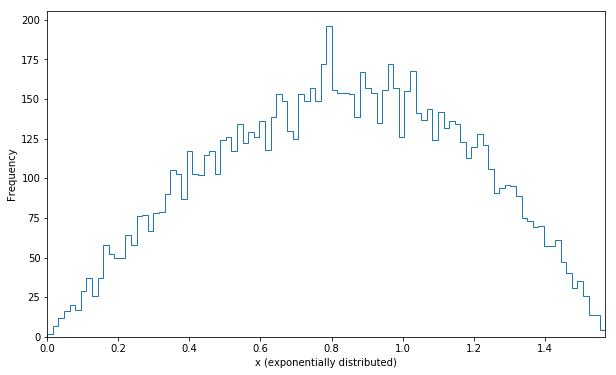

In [10]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.hist(xcos, bins=N_bins, range=(xmin2, xmax2), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin2, xmax2));

And plot $g(x)$ on top of the figure (notice, no fit here!) along with the legend, figure text and finally saves the figure:

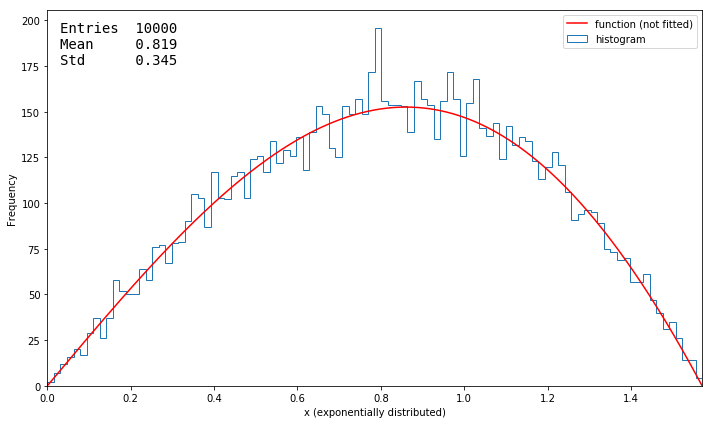

In [11]:
# g(x)
def xcos_func(x) :
    k = (xmax2-xmin2) / N_bins
    N = N_points * k
    return N * 1/integral * x * np.cos(x)

# plot f(x)
x_axis2 = np.linspace(xmin2, xmax2, 1000)
y_axis2 = xcos_func(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# define the figure text
d2 = {'Entries': len(xcos),
      'Mean': xcos.mean(),
      'Std': xcos.std(ddof=1),
    }

# add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text2, ax2, fontsize=14)

# add legend
ax2.legend(loc='best')
fig2.tight_layout()

# save figure
if save_plots: 
    fig2.savefig("Hist_xcos.pdf", dpi=600)
    
# show the figure
fig2

## Problem 3 (for you): 
#### Try to combine the two yourself.

Estimate the integral of $h(x) \sim \exp(-x/3)\cos(x)^2$ in the interval $[0, \infty]$ using a combination of Transformation and Hit-and-Miss method.

In [51]:
# We will not accept every y in the loop below, so we cannot know the final size beforehand so we just append to a list
expcos_x = []
expcos_y = []

N_hit = 0

for i in range(N_points):
    
    # Get an exponentially distributed number:
    x3 = r.exponential(3.0) #We multiply by 3 to get more values in the high x (aka takes less time to fill out the area under the graph)

    # Get a uniformly distributed number y and test if it is below cos(x)^2:
    y3 = r.uniform(0, np.exp(-x3/3))
    
    if (y3 < np.exp(-x3/3)*np.cos(x3)**2) :
        N_hit += 1
        expcos_x.append(x3)
        expcos_y.append(y3)
        
expcos_x = np.array(expcos_x)
expcos_y = np.array(expcos_y)

Calculate the fraction of points within the circle and its error:

In [52]:
f  = N_hit / N_points
ef = np.sqrt(f * (1.0-f) / N_points)

integral  = 3.0 * f       # Multiply integral of exponential alone with fraction
eintegral = 3.0 * ef      # Same for error

print(f"Integral of h(x) = exp(-x/3)*cos(x)^2, x in [0,inf] is: {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the HnM method used here is: \t {f:.2%} +/- {ef:.2%}")

Integral of h(x) = exp(-x/3)*cos(x)^2, x in [0,inf] is:  1.5528 +- 0.0150
The efficiency of the HnM method used here is: 	 51.76% +/- 0.50%


We plot the data:

[(0, 1), (0, 10)]

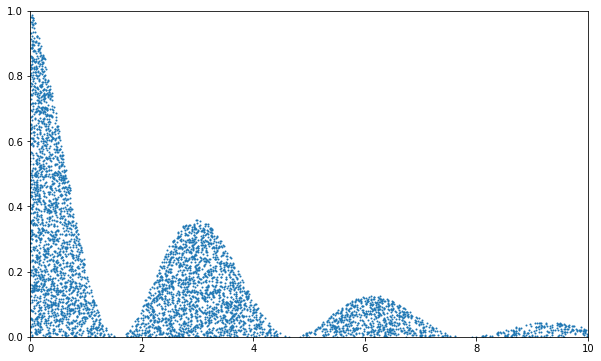

In [56]:
# Distribution of (x,y) points:
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.scatter(expcos_x, expcos_y, s=1, label='Scatter plot of data')
ax3.set(xlim=(0, 10), ylim=(0, 1))

And plot $h(x)$ on top of the figure (notice, no fit here!) along with the legend, figure text and finally saves the figure:

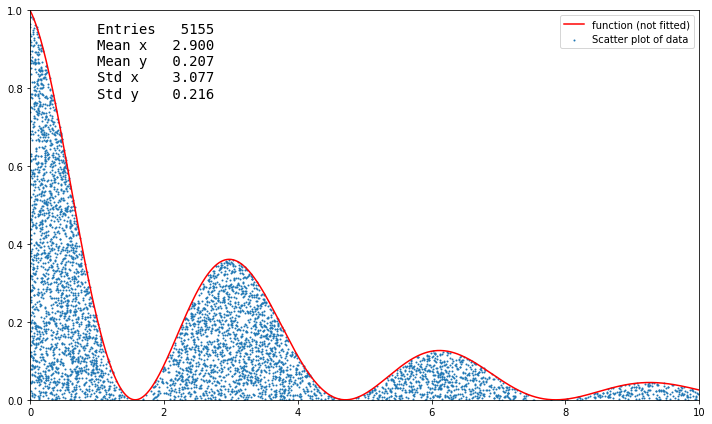

In [19]:
#h(x)
def expcos_func(x):
    return np.exp(-x/3)*np.cos(x)**2

# plot f(x)
x_axis3 = np.linspace(0, 10, 1000)
y_axis3 = expcos_func(x_axis3)
ax3.plot(x_axis3, y_axis3,'r-', label='function (not fitted)')

# make figure text
d3 = {'Entries': len(expcos_x),
      'Mean x': expcos_x.mean(),
      'Mean y': expcos_y.mean(),
      'Std x': expcos_x.std(ddof=1),
      'Std y': expcos_y.std(ddof=1),
     }

# add figure text
text3 = nice_string_output(d3, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.97, text3, ax3, fontsize=14)

# add legend
ax3.legend(loc='best')
fig3.tight_layout()

# save plot
if save_plots: 
    fig3.savefig("Hist_expcos.pdf", dpi=600)

# show plot
fig3

# Questions
1. Find the integral of $\exp(-x/3)\cos(x)^2$ in the interval $[0,\infty]$ using a combination of the Transformation and Hit-and-Miss methods.